In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GRU



In [ ]:
df_train=pd.read_csv('train-data.csv')
df_test=pd.read_csv('test-data.csv')

In [ ]:
df_train.isna().sum()

Unnamed: 0        0
clean training    0
label             0
dtype: int64

In [ ]:
df_train=df_train.dropna()

In [ ]:
df_train= df_train.astype({'label': int})

In [ ]:
df_test.isna().sum()

Unnamed: 0        0
clean training    0
label             0
dtype: int64

In [ ]:
# Define BERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# Tokenize text data
MAX_LEN = 128
X_train_tokenized = tokenizer.batch_encode_plus(
    df_train['clean training'].tolist(),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False
)
X_test_tokenized = tokenizer.batch_encode_plus(
    df_test['clean training'].tolist(),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False
)

In [ ]:
# Create input tensors
attention_masks = np.array(X_train_tokenized['attention_mask'])
X_train = np.array(X_train_tokenized['input_ids'])
X_test = np.array(X_test_tokenized['input_ids'])

y_train = np.array(df_train['label'])
y_test = np.array(df_test['label'])

In [ ]:
# Define input layer for BERT model
input_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")

# Connect tokenizer output to BERT model
bert_output = bert_model(input_layer)[0]

# Define GRU layer
gru_layer = Bidirectional(GRU(128, return_sequences=True))(bert_output)
# Define pooling layer
pooling_layer = pooling_layer = GlobalMaxPooling1D()(gru_layer) # or GlobalAveragePooling1D()

# Define output layer
output_layer = Dense(3, activation='softmax')(pooling_layer)

# Define the model
model = Model(inputs=[input_layer], outputs=[output_layer])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

In [ ]:
# Train model
history = model.fit(
    x=X_train,
    y=y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=16,
    callbacks=[EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)]
)

Epoch 1/3
6094/6094 [==============================] - 1451s 238ms/step - loss: 0.2388 - accuracy: 0.8930 - val_loss: 0.4681 - val_accuracy: 0.8159
Epoch 2/3
6094/6094 [==============================] - 1451s 238ms/step - loss: 0.1931 - accuracy: 0.9121 - val_loss: 0.4807 - val_accuracy: 0.8185


In [ ]:
# Evaluate model on test set
batch_size = 16  # Set batch size to the same value as used in training
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test accuracy:', accuracy)


1905/1905 [==============================] - 143s 75ms/step - loss: 0.4574 - accuracy: 0.8229
Test accuracy: 0.8228845000267029


In [ ]:
# Use model to make predictions
text = "Most of Asian are bad drivers"
text_tokenized = tokenizer.encode_plus(
    text,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False
)
text_input = np.array(text_tokenized['input_ids']).reshape(1, -1)
prediction = model.predict(text_input)
predicted_label = np.argmax(prediction)
print('Predicted label:', predicted_label)

1/1 [==============================] - 2s 2s/step
Predicted label: 2


In [ ]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1) 

# Print Classification report
from sklearn.metrics import classification_report
print(f"\nClassification Report :\n{classification_report(y_test, y_pred)}")

953/953 [==============================] - 131s 137ms/step

Classification Report :
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      9794
           1       0.83      0.84      0.84     10406
           2       0.79      0.72      0.75     10266

    accuracy                           0.82     30466
   macro avg       0.82      0.82      0.82     30466
weighted avg       0.82      0.82      0.82     30466



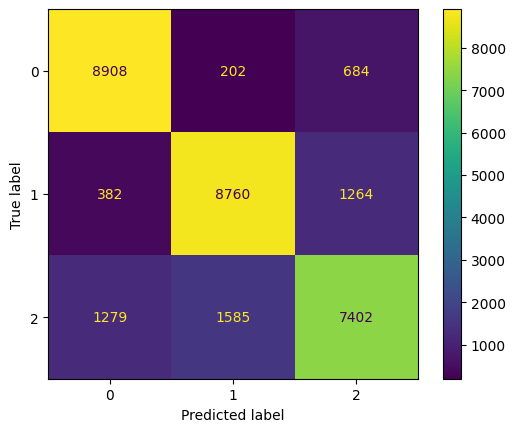

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()
